In [1]:
import datetime
import dateutil
import os
from glob import glob
from pathlib import Path
import xml.etree.ElementTree as ET

import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.linalg import norm
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import folium
import pymap3d
import pyproj
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
pyproj.network.set_network_enabled(True)

# dem の確認
補正のために必要な dem を可視化してみる

In [2]:
# 標高起伏データから陰影起伏 (Hillshade) を計算する
def get_hillshade(Z, center_Lat, azimuth_deg=315, altitude_deg=45):
    
    # ref: https://memomemokun.hateblo.jp/entry/2018/12/22/205419
    #      https://pro.arcgis.com/ja/pro-app/2.8/tool-reference/3d-analyst/applying-a-z-factor.htm
    latitudes = [i * 10 for i in range(9)]
    Z_factors = [0.00000898, 0.00000912, 0.00000956, 0.00001036, 0.00001171, 0.00001395, 0.00001792, 0.00002619, 0.00005156]
    f_Z_factor = interpolate.interp1d(latitudes, Z_factors, kind='cubic')

    # 勾配(傾き)を求める
    Zx, Zy = np.gradient(Z)

    # 傾斜角
    Slope_rad = np.arctan(500 * f_Z_factor(center_Lat) * np.sqrt(Zx*Zx + Zy*Zy))

    # 傾斜方向
    Aspect_rad = np.arctan2(-Zx, Zy)

    # 太陽の方位角をラジアンに変換
    Azimuth_rad = np.radians(azimuth_deg)

    # 太陽の天頂角をラジアンに変換
    Zenith_rad = np.radians(90 - altitude_deg)

    # 陰影起伏
    shaded = np.cos(Zenith_rad) * np.cos(Slope_rad) + np.sin(Zenith_rad) * np.sin(Slope_rad) * np.cos(Azimuth_rad - Aspect_rad)
    return 255 * shaded

def equalize_img(img, pmin=2, pmax=98):
    img = (img - np.percentile(img, pmin)) / (np.percentile(img, pmax) - np.percentile(img, pmin)) * 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

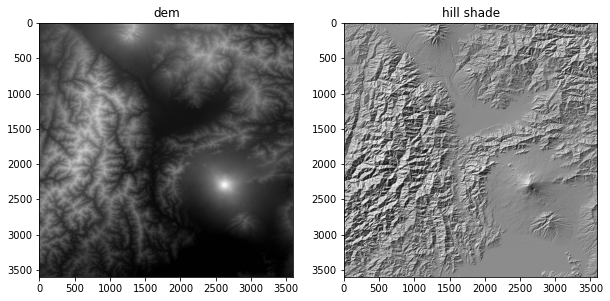

In [32]:
# demは、AW3D30　を使う
# https://www.eorc.jaxa.jp/ALOS/jp/dataset/aw3d30/aw3d30_j.htm

dem_path = "../data/dem/N035E138/ALPSMLC30_N035E138_DSM.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1)
    yy, xx = np.meshgrid([x for x in range(dem.shape[1])], [y for y in range(dem.shape[0])])
    lons, lats =rasterio.transform.xy(src.transform, xx, yy)
    lats = np.array(lats)
    hillshade = get_hillshade(dem, np.mean(lats))
    hillshade = equalize_img(hillshade)
    
fig, axx = plt.subplots(1, 2, figsize=(10, 5))
axx[0].imshow(dem, cmap="gray")
axx[0].set_title("dem")
axx[1].imshow(hillshade, cmap="gray")
axx[1].set_title("hill shade")
plt.show()

# sentinel-1 grd のダウンロード

sentinel-1 の grd (ground range detected) プロダクトで、富士山が写っているのを探す

In [16]:
# get user infomation
DHUS_USER = os.getenv("DHUS_USER")
DHUS_PASSWORD = os.getenv("DHUS_PASSWORD")
api = SentinelAPI(DHUS_USER, DHUS_PASSWORD)
aoi_path = "../data/aoi/aoi.geojson"

# search by polygon, time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson(aoi_path))
products = api.query(footprint,
                     date=('20220801', '20220831'),
                     platformname='Sentinel-1')
products_df = api.to_dataframe(products)

uuid = products_df.loc[products_df['producttype']=='GRD'].iloc[0]['uuid']

AOI と sentinel-1 の foot print を確認

In [26]:
df_aoi = gpd.read_file(aoi_path)
df_aoi.crs = 'epsg:4326'
df_footprints = gpd.GeoSeries.from_wkt(products_df["footprint"])

lon, lat = df_aoi.geometry[0].centroid.xy
m = folium.Map([lat[0], lon[0]], zoom_start=8)
folium.GeoJson(aoi_path).add_to(m)
folium.GeoJson(df_footprints.loc[uuid]).add_to(m)
m

良さそうなのでダウンロード

In [24]:
dst_dir = "../data/sentinel"
api.download(uuid, directory_path=dst_dir)

MD5 checksumming:   0%|          | 0.00/935M [00:00<?, ?B/s]

{'id': '5d116803-f88a-4140-bc65-9cc0d7b565b9',
 'title': 'S1A_IW_GRDH_1SDV_20220827T204353_20220827T204418_044743_0557A9_650C',
 'size': 934780611,
 'md5': '248e84142408ceeefbaf53ba4c1c2c48',
 'date': datetime.datetime(2022, 8, 27, 20, 43, 53, 565000),
 'footprint': 'POLYGON((140.782425 34.113422,138.043625 34.517006,138.346725 36.019775,141.136627 35.618168,140.782425 34.113422))',
 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('5d116803-f88a-4140-bc65-9cc0d7b565b9')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 8, 28, 3, 47, 6, 213000),
 'Ingestion Date': datetime.datetime(2022, 8, 28, 3, 46, 20, 852000),
 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('5d116803-f88a-4140-bc65-9cc0d7b565b9')/Products('Quicklook')/$value",
 'path': '../data/sentinel/S1A_IW_GRDH_1SDV_20220827T204353_20220827T204418_044743_0557A9_650C.zip',
 'downloaded_bytes': 934780611}

# dem と sentinel-1 grd の可視化

sentinel-1 のメタデータから、footprint と衛星軌道を確認してみる。

太平洋側から撮像されていることがわかる

In [28]:
img_root_dir = Path("../data/sentinel/S1A_IW_GRDH_1SDV_20220827T204353_20220827T204418_044743_0557A9_650C.SAFE")
img_path = img_root_dir / Path("measurement/s1a-iw-grd-vv-20220827t204353-20220827t204418-044743-0557a9-001.tiff")
annotation_path = img_root_dir / Path("annotation/s1a-iw-grd-vv-20220827t204353-20220827t204418-044743-0557a9-001.xml")
footprint_path = img_root_dir / Path("preview/map-overlay.kml")

root = ET.parse(footprint_path)
for footprint in root.iter("coordinates"):
    footprint = [[float(lonlat.split(",")[0]), float(lonlat.split(",")[1])] for lonlat in footprint.text.split(" ")]
    footprint = Polygon(footprint)
    
tree = ET.parse(annotation_path)
root = tree.getroot()
sat_positions = []
for positions in root.iter("position"):
    sat_position = []
    for position in positions:
        sat_position.append(float(position.text))
    sat_positions.append(sat_position)
m = folium.Map(location=[footprint.centroid.y, footprint.centroid.x], zoom_start=6)
folium.GeoJson(footprint).add_to(m)
folium.GeoJson(LineString([pymap3d.ecef.ecef2geodetic(*position)[:2][::-1] for position in sat_positions])).add_to(m)

m

富士山周辺を切り抜いてみる

In [29]:
gdf_aoi = gpd.read_file("../data/aoi/aoi.geojson")

m = folium.Map(location=[footprint.centroid.y, footprint.centroid.x], zoom_start=8)
folium.GeoJson(footprint).add_to(m)
folium.GeoJson(gdf_aoi).add_to(m)
m

適当に warp して、dem と sentinel-1 grd をそろえる

In [33]:
with rasterio.open(img_path) as src:
    gcps, _ = src.gcps
    dst_crs = 'EPSG:4326'
    transform = rasterio.transform.from_gcps(gcps)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
    })
    with rasterio.open('sentinel-1_grd_geocoded.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.cubic)
            
with rasterio.open("sentinel-1_grd_geocoded.tif") as src:
    with rasterio.open(dem_path) as src_ref:
        kwargs = src.meta.copy()
        
        kwargs.update({
            'crs': src_ref.crs,
            'transform': src_ref.transform,
            'width': src_ref.width,
            'height': src_ref.height
        })
        
    with rasterio.open('sentinel-1_grd_warp.tif', 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=src.transform,
            dst_crs=src.crs,
            resampling=Resampling.cubic)

sentinel-1 grd と　dem を重ね合わせてみる。

富士山頂など、標高が高い場所が、右側、つまり衛星側にシフトしていることがわかる（foreshortening）。

これを補正したい。

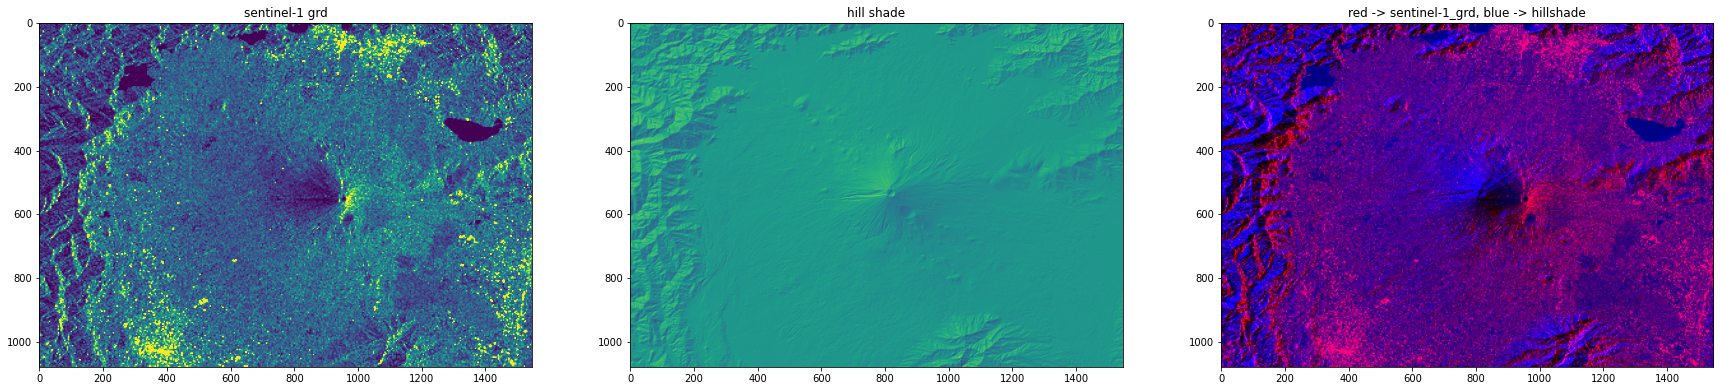

In [34]:
fig, axx = plt.subplots(1, 3, figsize=(30, 10))

with rasterio.open('sentinel-1_grd_warp.tif') as src:
    grd_img, _ = rasterio.mask.mask(src, gdf_aoi.geometry, crop=True)
    grd_img = grd_img[0, :, :]
axx[0].imshow(grd_img, vmin=np.percentile(grd_img, 2), vmax=np.percentile(grd_img, 98))
axx[0].set_title("sentinel-1 grd")

with rasterio.open(dem_path) as src:
    dem, transform = rasterio.mask.mask(src, gdf_aoi.geometry, crop=True)
    dem = dem[0,:,:]
    yy, xx = np.meshgrid([x for x in range(dem.shape[1])], [y for y in range(dem.shape[0])])
    lons, lats =rasterio.transform.xy(transform, xx, yy)
    lons = np.array(lons)
    lats = np.array(lats)
    hillshade = get_hillshade(dem, np.mean(lats))
axx[1].imshow(hillshade)
axx[1].set_title("hill shade")

diff = np.zeros((hillshade.shape[0], hillshade.shape[1], 3)).astype("uint8")
grd_img = equalize_img(grd_img)
hillshade = equalize_img(hillshade)
diff[:,:,0] = grd_img
diff[:,:,2] = hillshade
axx[2].imshow(diff)
axx[2].set_title("red -> sentinel-1_grd, blue -> hillshade")

plt.show()

# 補正

sentinel-1 grd プロダクトには、メタデータを使うことで、各ピクセルの azimuth_time (そのピクセルが撮像された timestamp ) と slant_range_time (そのピクセルと衛星をマイクロ波が往復する時間) がわかる。
dem に関して、同様に各ピクセルの azimuth_time と slant_range_time がわかれば、dem と sentinel-1 grd のピクセルが 1対1 で対応し、補正が可能になる。

ここでいう　azimuth_time は、ドップラーシフトがゼロになる時間で定義される。ドップラーシフトがゼロということは、衛星速度ベクトルとマイクロ波照射方向ベクトルが鉛直に交わる。したがって、dem 上のとあるポイントの azimuth_time は、そのポイントから衛星軌道にベクトルを張ったときに、衛星速度ベクトルと鉛直になる時の衛星位置の timestamp になる。azimuth_time がわかれば同様に衛星座標もわかるため、dem 上のポイントからの slant_range_time も同様に算出できる。

まとめると、補正には以下の情報が必要。
- dem
- dem　上の各点における　azimuth_time と　slant_range_time
- SAR 画像
- SAR 画像上の各ピクセルにおける azimuth_time と slant_range_time

## 補正用の dem データ作成

dem の位置のECEFなどの3次元座標に変換するためには、緯度・経度と楕円体高が必要。

dem (AW3D30) は、標高なので、標高から楕円体高に変換する。

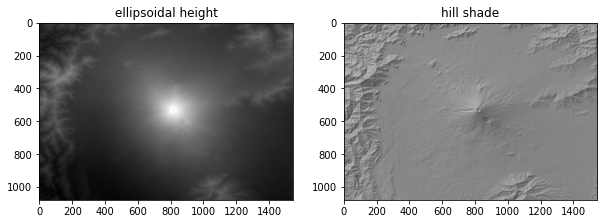

In [56]:
# dem

with rasterio.open(dem_path) as src:
    
    dem, transform = rasterio.mask.mask(src, gdf_aoi.geometry, crop=True)
    dem = dem[0,:,:]
    #dem = src.read(1)
    yy, xx = np.meshgrid([x for x in range(dem.shape[1])], [y for y in range(dem.shape[0])])
    lons, lats =rasterio.transform.xy(transform, xx, yy)
    lons = np.array(lons)
    lats = np.array(lats)
    hillshade = get_hillshade(dem, np.mean(lats))
    hillshade = equalize_img(hillshade)
    
# epsg:4326 -> epsg:6697 に変換
# epsg:6697 は日本付近における、ジオイド面を基準とした座標系

tr = pyproj.Transformer.from_crs(4326,6697)
_, _, ellipsoid_from_geiod = tr.transform(lats, lons, np.zeros(lats.shape))

ellipsoidal_height = dem - ellipsoid_from_geiod
fig, axx = plt.subplots(1, 2, figsize=(10, 5))
axx[0].imshow(ellipsoidal_height, cmap="gray")
axx[0].set_title("ellipsoidal height")
axx[1].imshow((get_hillshade(ellipsoidal_height, np.mean(lats))), cmap="gray")
axx[1].set_title("hill shade")
plt.show()


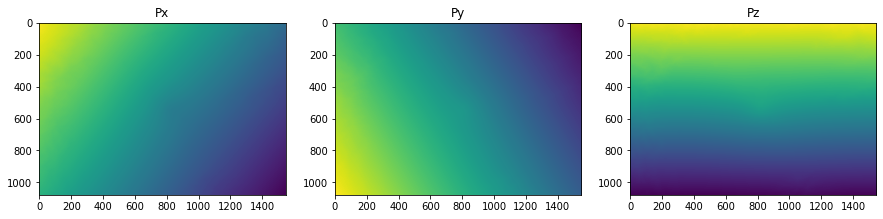

In [57]:
# 緯度、経度、楕円体高を、ecef座標系に変換
Px, Py, Pz = pymap3d.ecef.geodetic2ecef(lats, lons, ellipsoidal_height)

fig, axx = plt.subplots(1, 3, figsize=(15, 5))
axx[0].imshow(Px)
axx[0].set_title("Px")
axx[1].imshow(Py)
axx[1].set_title("Py")
axx[2].imshow(Pz)
axx[2].set_title("Pz")
plt.show()

In [58]:
# 衛星の位置・速度の補完関数を算出

tree = ET.parse(annotation_path)
root = tree.getroot()
sat_positions = []
for positions in root.iter("position"):
    sat_position = []
    for position in positions:
        sat_position.append(float(position.text))
    sat_positions.append(sat_position)

sat_velocities = []
for velocities in root.iter('velocity'):
    sat_velocity = []
    for velocity in velocities:
        sat_velocity.append(float(velocity.text))
    sat_velocities.append(sat_velocity)
    
orbit_timestamps = []
for orbit in root.iter("orbit"):
    for t in orbit.iter('time'):
        orbit_timestamps.append(dateutil.parser.parse(t.text).timestamp())
orbit_timestamp_ref = orbit_timestamps[0]
orbit_timestamps = [orbit_timestamp - orbit_timestamp_ref for orbit_timestamp in orbit_timestamps]

position_spline_funcs = []
for i in range(3):
    position_spline_funcs.append(interpolate.interp1d(orbit_timestamps, np.array(sat_positions)[:,i], kind='cubic'))
    
velocity_spline_funcs = []
for i in range(3):
    velocity_spline_funcs.append(interpolate.interp1d(orbit_timestamps, np.array(sat_velocities)[:,i], kind='cubic'))

In [59]:
# 緯度経度および楕円体高から、zero doppler timestamp を算出する
# 三分探索でやってるけど、解析的にできそう
def get_timestamp(lats, lons, heights, orbit_timestamps, velocity_spline_funcs, position_spline_funcs):
    def _calc_dot(timestamp):
        V = np.array([velocity_spline_func(timestamp) for velocity_spline_func in velocity_spline_funcs])
        X = np.array([position_spline_func(timestamp) for position_spline_func in position_spline_funcs])
        X -= np.array([xx, yy, zz])
        V /= norm(V)
        X /= norm(X)
        return abs(np.sum((X * V), axis=0))

    xx, yy, zz = pymap3d.ecef.geodetic2ecef(lats, lons, heights)
    lefts = np.full(xx.shape, orbit_timestamps[0])
    rights = np.full(xx.shape, orbit_timestamps[-1])
    while ((rights - lefts) > 1e-5).any():
        mid1 = lefts + (rights - lefts) / 3
        mid2 = lefts + (rights - lefts) / 3 * 2

        res1 = _calc_dot(mid1)
        res2 = _calc_dot(mid2)

        rights = np.where(res2 > res1, mid2, rights)
        lefts = np.where(res1 >= res2, mid1, lefts)
        
    return lefts

In [60]:
azimuth_time_dem = get_timestamp(lats, lons, ellipsoidal_height, orbit_timestamps, velocity_spline_funcs, position_spline_funcs)
sat_position_dem = np.array([position_spline_func(azimuth_time_dem) for position_spline_func in position_spline_funcs])
slant_range_dem = np.sqrt(np.sum((np.array([Px, Py, Pz]) - sat_position_dem)**2, axis=0))
light_speed = 299792458
slant_range_time_dem = slant_range_dem * 2 / light_speed

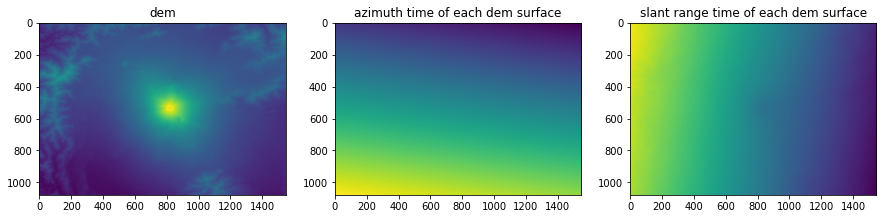

In [61]:
fig, axx = plt.subplots(1, 3, figsize=(15, 5))
axx[0].imshow(dem)
axx[0].set_title("dem")
axx[1].imshow(azimuth_time_dem)
axx[1].set_title("azimuth time of each dem surface")
axx[2].imshow(slant_range_time_dem)
axx[2].set_title("slant range time of each dem surface")
plt.show()

In [62]:
# read sentinel-1 grd image
with rasterio.open(img_path) as src:
    grd_img = src.read(1)

# read sentinel-1 metadata
tree = ET.parse(annotation_path)
root = tree.getroot()

lines = []
pixels = []
slant_range_times = []
azimuth_times = []
for geolocationGrid in root.iter("geolocationGrid"):
    for geolocationGridPoint in geolocationGrid.iter("geolocationGridPoint"):
        for item in geolocationGridPoint.iter("line"):
            lines.append(int(item.text))
        for item in geolocationGridPoint.iter("pixel"):
            pixels.append(int(item.text))
        for item in geolocationGridPoint.iter("slantRangeTime"):
            slant_range_times.append(float(item.text))
        for item in geolocationGridPoint.iter("azimuthTime"):
            azimuth_times.append(dateutil.parser.parse(item.text).timestamp())

#azimuth_times = [azimuth_time - orbit_timestamp_ref for azimuth_time in azimuth_times]
            
# 補完

Y = np.arange(0, max(lines), 1)
X = np.arange(0, max(pixels), 1)
XX, YY = np.meshgrid(X, Y)

f_slant_range_time = interpolate.interp2d(pixels, lines, slant_range_times, kind='cubic')
f_azimuth_time = interpolate.interp2d(pixels, lines, azimuth_times, kind='cubic')
slant_range_time_sar = f_slant_range_time(X, Y)
azimuth_time_sar = f_azimuth_time(X, Y) - orbit_timestamp_ref

/Users/dai/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=20,18 m=210 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


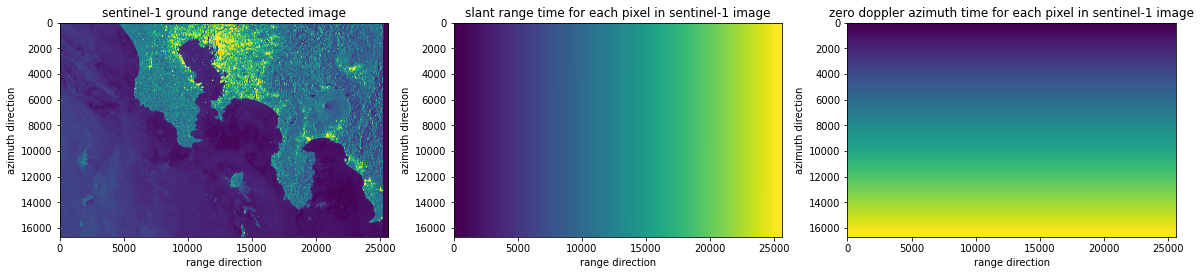

In [63]:
fig, axx = plt.subplots(1, 3, figsize=(20, 5))
axx[0].imshow(grd_img, vmin=np.percentile(grd_img, 2), vmax=np.percentile(grd_img, 98))
axx[0].set_title("sentinel-1 ground range detected image")
axx[1].imshow(equalize_img(slant_range_time_sar))
axx[1].set_title("slant range time for each pixel in sentinel-1 image")
axx[2].imshow(equalize_img(azimuth_time_sar))
axx[2].set_title("zero doppler azimuth time for each pixel in sentinel-1 image")
for ax in axx:
    ax.set_xlabel("range direction")
    ax.set_ylabel("azimuth direction")
plt.show()

In [64]:
orthorectified = np.zeros(dem.shape)
range_table = slant_range_time_sar[slant_range_time_sar.shape[0]//2, :]
azimuth_table = azimuth_time_sar[:, azimuth_time_sar.shape[1]//2]

for i in tqdm.tqdm(range(dem.shape[0])):
    for j in range(dem.shape[1]):
        azimuth_time = azimuth_time_dem[i, j]
        slant_range_time = slant_range_time_dem[i, j]
        i_sar = np.argmin(np.abs(azimuth_table - azimuth_time))
        j_sar = np.argmin(np.abs(range_table - slant_range_time))
        orthorectified[i, j] = grd_img[i_sar, j_sar]

100%|███████████████████████████████████████| 1079/1079 [03:10<00:00,  5.67it/s]


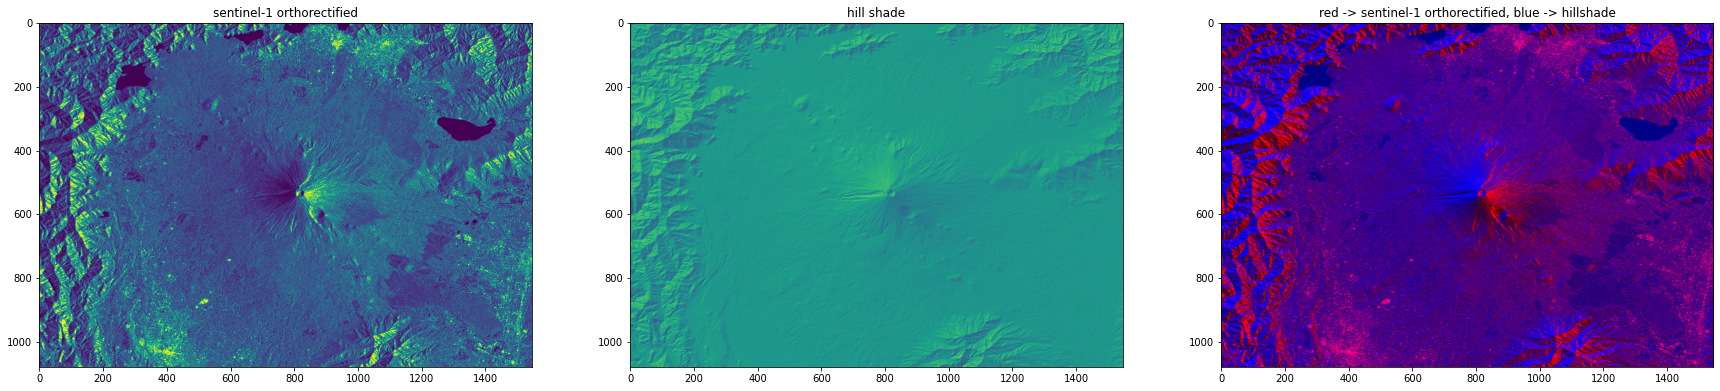

In [65]:
fig, axx = plt.subplots(1, 3, figsize=(30, 10))

axx[0].imshow(equalize_img(orthorectified))
axx[0].set_title("sentinel-1 orthorectified")

with rasterio.open(dem_path) as src:
    dem, transform = rasterio.mask.mask(src, gdf_aoi.geometry, crop=True)
    dem = dem[0,:,:]
    yy, xx = np.meshgrid([x for x in range(dem.shape[1])], [y for y in range(dem.shape[0])])
    lons, lats =rasterio.transform.xy(transform, xx, yy)
    lons = np.array(lons)
    lats = np.array(lats)
    hillshade = get_hillshade(dem, np.mean(lats))
axx[1].imshow(hillshade)
axx[1].set_title("hill shade")

diff = np.zeros((hillshade.shape[0], hillshade.shape[1], 3)).astype("uint8")
diff[:,:,0] = equalize_img(orthorectified)
diff[:,:,2] = equalize_img(hillshade)
axx[2].imshow(diff)
axx[2].set_title("red -> sentinel-1 orthorectified, blue -> hillshade")

plt.show()